<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# загрузка библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split # разбивка выборки на обучающую и валидационную
from sklearn.metrics import mean_squared_error # MSE 
# rmse = mse**0.5 - корень из средней квадратичной ошибки
from sklearn.model_selection import RandomizedSearchCV # оценка оптимальных параметров методом кроссвалидации
from statsmodels.tsa.seasonal import seasonal_decompose # тренд сезонность
from sklearn.model_selection import TimeSeriesSplit # правильные временные фолды
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.model_selection import cross_val_score #cv
import warnings # убрать предупреждения
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor



In [2]:
!pip install lightgbm

In [3]:
# установили LGBMRegressor
from lightgbm import LGBMRegressor

In [4]:
# prophet 
!pip install prophet

     |████████████████████████████████| 8.9 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 226 kB 70.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 57.5 MB/s eta 0:00:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.11.3.1
    Uninstalling holidays-0.11.3.1:
      Successfully uninstalled holidays-0.11.3.1


In [5]:
from prophet import Prophet

In [6]:
# загрузка данных
data = pd.read_csv('/datasets/taxi.csv')

In [8]:
# посмотрим
display(data.head(10))

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Количество заказов за каждые 10 минут. Уже отсортированы.
<br>
Нужно ресемплировать по 1 часу + нужна сумма, т.к. предсказать надо общее кол-во заказов за час.

Text(0.5, 1.0, 'Суммарное количество заказов за 1 час с 2018-03-01')

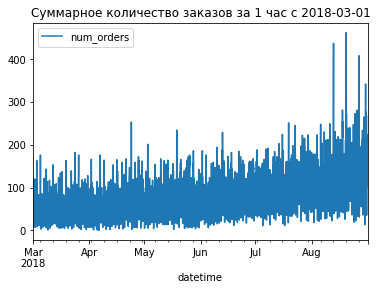

In [9]:
data = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
data.sort_index(inplace=True) # отсортировали
data = data.resample('1H').sum() # реемплировали 
data.plot()
plt.title("Суммарное количество заказов за 1 час с 2018-03-01")

На этом графике ничего не видно. Нужно изменить масштаб.
<br>
Нужно выявить тренд и сезонную компоненту.
<br><br>
Ощущение, что с Июня ростущий тренд. Значит временной ряд не стационарный, предсказать его будет сложно. (Если бы были данные за несколько лет, можно было бы понять, возможно в летние месяцы заказов всегда побольше).

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


In [49]:
# проверим есть ли пропуски
print(data.isna().sum())

num_orders    0
dtype: int64


In [50]:
# к целочисленному формату
data['num_orders'] = data['num_orders'].astype('int')

## Анализ

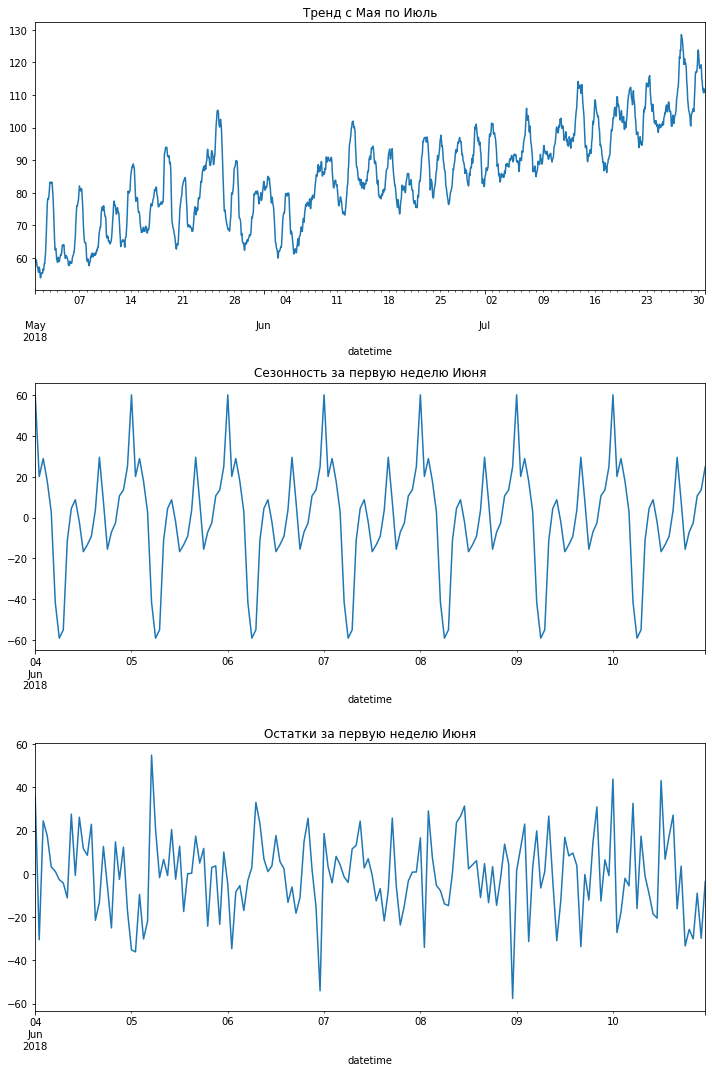

In [16]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed.trend['2018-05-01':'2018-07-30'].plot(ax=plt.gca())
plt.title('Тренд с Мая по Июль')

plt.subplot(312)
decomposed.seasonal['2018-06-04':'2018-06-10'].plot(ax=plt.gca())
plt.title('Сезонность за первую неделю Июня')


plt.subplot(313)
decomposed.resid['2018-06-04':'2018-06-10'].plot(ax=plt.gca())
plt.title('Остатки за первую неделю Июня')
plt.tight_layout()

Ярко выражена сезонность по часам внутри. Утром суммарное количество заказов сильно растет (условно пассажиры едут на работу). Днем - корректируется. Вечером продолжается рост до максимум (условно пассажиры возвращаются с работы). После полуночи количество заказов снижается - люди спят.
<br><br>
Остатки в переделах 40 по модулю (MAE). В принципе соответствует RMSE 48 (по заданию).
<br><br>
Есть ли внутринедельная сезонность на количество заказов - наблюдается ли роста числа заказов такси в выходные?

In [22]:
# ресемплировали
data_1d = data.resample('1D').sum()
# декомпозировали
decomposed_1 = seasonal_decompose(data_1d)

Text(0.5, 1.0, 'Тренд с за вторую неделю Мая')

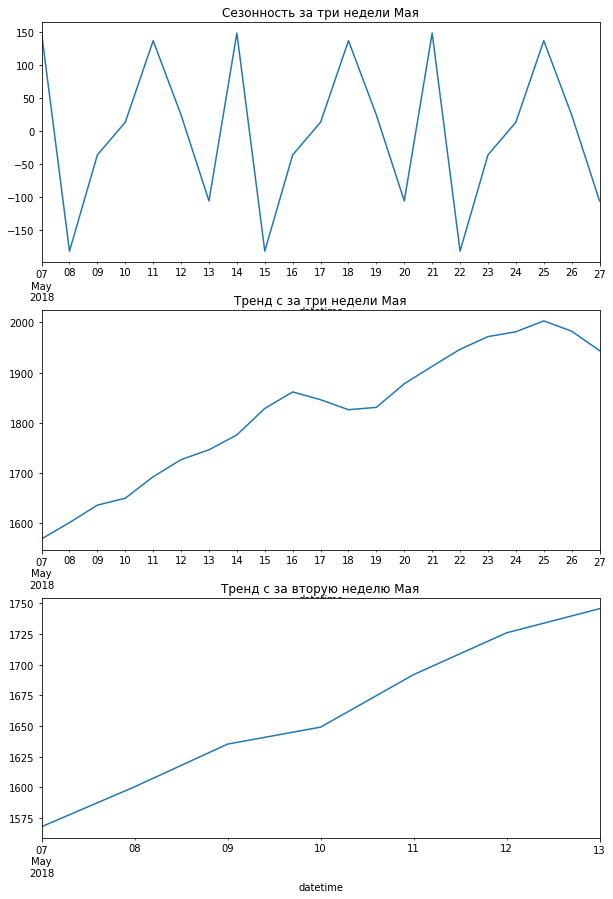

In [24]:
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed_1.seasonal['2018-05-7':'2018-05-27'].plot(ax=plt.gca())
plt.title('Сезонность за три недели Мая')


plt.subplot(312)
decomposed_1.trend['2018-05-7':'2018-05-27'].plot(ax=plt.gca())
plt.title('Тренд с за три недели Мая')

plt.subplot(313)
decomposed_1.trend['2018-05-7':'2018-05-13'].plot(ax=plt.gca())
plt.title('Тренд с за вторую неделю Мая')

Text(0.5, 1.0, 'Тренд за весь период')

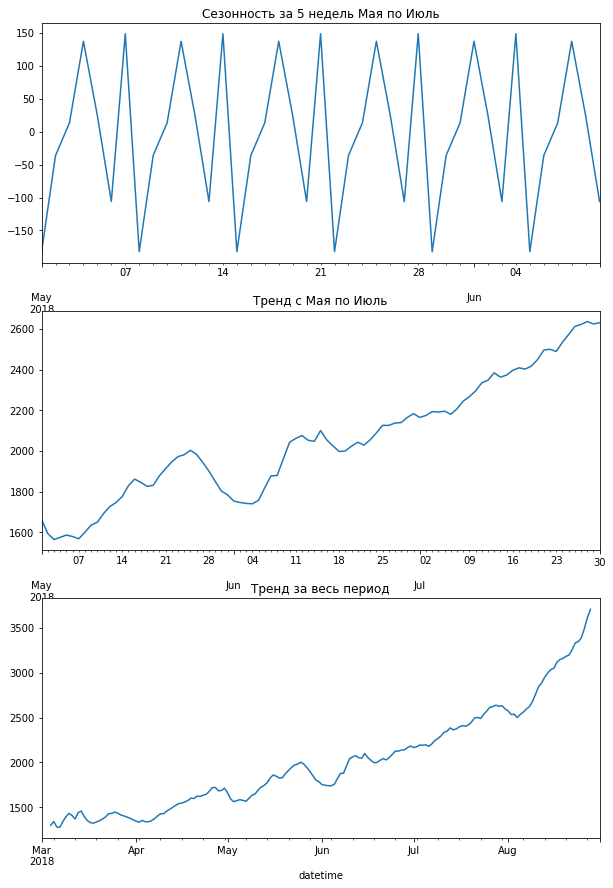

In [31]:
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed_1.seasonal['2018-05-01':'2018-06-10'].plot(ax=plt.gca())
plt.title('Сезонность за 5 недель Мая по Июль')


plt.subplot(312)
decomposed_1.trend['2018-05-01':'2018-07-30'].plot(ax=plt.gca())
plt.title('Тренд с Мая по Июль')

plt.subplot(313)
decomposed_1.trend.plot(ax=plt.gca())
plt.title('Тренд за весь период')

Недельная сезонность также есть:  <br>
Вт, Ср, Чт, Пт - количество заказов в день растет<br>
Сб, Вск - количество заказов снижается<br>
Вск Пн - корректируется (со вторника по среду снова начинается рост) <br>
<br>
Но этот тренд виден на данных количествах заказов ресемплированных по дням. На часовых графиках эта сезонность не заметна.
<br><br>
При ресемплировании данных по дням (суммарное количество заказов в день), видно, что тренд все-таки растущий. Это будет как минимум усложнять предсказания по часам.

In [44]:
def plotMovingAverage(series, n):
    
    rolling_mean = series.rolling(window=n).mean().shift(1)
    
    rolling_std =  series.rolling(window=n).std().shift(1)
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    
    
    plt.figure(figsize=(15,5))
    plt.title("Суммарное количество заказов за первую неделю Июня и скользящее среднее за\n часов = {}".format(n))
    plt.plot(rolling_mean, "g", label="Скользящее среднее")
    
    plt.plot(upper_bond, "r--", label="Верхняя граница / Нижняя граница")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n+1:], label="Суммарное количество заказов")
    plt.legend(loc="upper left")
    plt.grid(True)

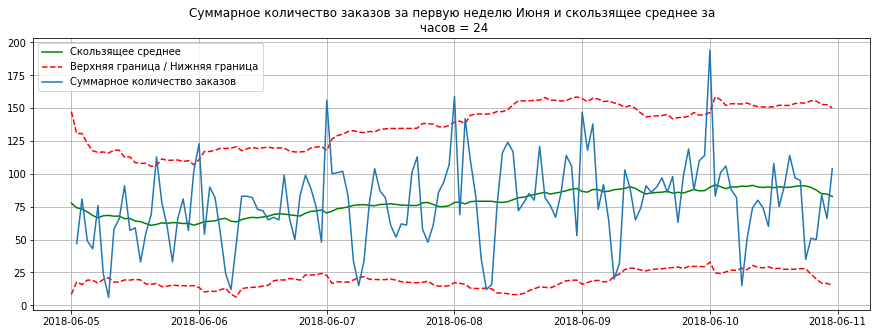

In [45]:
plotMovingAverage(data['2018-06-04':'2018-06-10'], 24)

## Обучение

In [51]:
# разобьем на train, test до вычисления средних для генерации фичей, чтобы не было утечки 

train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [52]:
# функция, которая создаст переменные 
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [53]:
# сделаем фичи для train
# лаг - 12 часов (лучше было 24, но тогда теряем из-за содания пропусков данные в тестовой)
# скользящая средня по окну в 24 часа
make_features(train, 12, 24)

In [54]:
# посмотрим
display(train.sample(10))

,num_orders,hour,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-07-20 13:00:00,105,13,7,20,4,0,92.0,110.0,137.0,137.0,87.0,33.0,44.0,60.0,110.0,101.0,160.0,119.0,99.041667
2018-04-04 20:00:00,54,20,4,4,2,0,83.0,42.0,35.0,72.0,66.0,48.0,53.0,33.0,66.0,69.0,56.0,43.0,48.583333
2018-07-03 03:00:00,104,3,7,3,1,0,103.0,121.0,149.0,121.0,71.0,83.0,89.0,96.0,54.0,103.0,85.0,115.0,93.541667
2018-05-22 20:00:00,77,20,5,22,1,0,76.0,44.0,64.0,124.0,60.0,62.0,66.0,55.0,77.0,95.0,55.0,74.0,67.833333
2018-04-17 21:00:00,80,21,4,17,1,0,82.0,71.0,49.0,51.0,98.0,59.0,46.0,57.0,32.0,78.0,82.0,44.0,57.250000
2018-06-10 19:00:00,51,19,6,10,6,1,35.0,95.0,97.0,114.0,91.0,75.0,108.0,60.0,74.0,80.0,74.0,51.0,89.666667
2018-07-04 04:00:00,104,4,7,4,2,0,94.0,109.0,101.0,142.0,145.0,65.0,90.0,61.0,95.0,78.0,108.0,130.0,84.500000
2018-08-08 17:00:00,95,17,8,8,2,0,196.0,85.0,80.0,99.0,85.0,110.0,130.0,122.0,113.0,27.0,60.0,86.0,108.041667
2018-03-05 02:00:00,32,2,3,5,0,0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,52.833333


In [55]:
# удалим пропуски созданные из-за лагов и скользящей средней
train = train.dropna()

In [57]:
# сделаем фичи для test
make_features(test, 12, 24)
# удалим пропуски созданные из-за лагов и скользящей средней
test = test.dropna()

In [58]:
# посмотрим на результат
display(test.head(5))

,num_orders,hour,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-08-14 14:00:00,112,14,8,14,1,0,64.0,114.0,162.0,155.0,135.0,91.0,54.0,45.0,47.0,139.0,190.0,108.0,121.750000
2018-08-14 15:00:00,116,15,8,14,1,0,112.0,64.0,114.0,162.0,155.0,135.0,91.0,54.0,45.0,47.0,139.0,190.0,122.166667
2018-08-14 16:00:00,111,16,8,14,1,0,116.0,112.0,64.0,114.0,162.0,155.0,135.0,91.0,54.0,45.0,47.0,139.0,119.708333
2018-08-14 17:00:00,152,17,8,14,1,0,111.0,116.0,112.0,64.0,114.0,162.0,155.0,135.0,91.0,54.0,45.0,47.0,118.333333
2018-08-14 18:00:00,98,18,8,14,1,0,152.0,111.0,116.0,112.0,64.0,114.0,162.0,155.0,135.0,91.0,54.0,45.0,118.333333


In [59]:
# разделим на фичи и таргет

features_train = train.drop(['num_orders'], axis=1) 
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [60]:
print(features_train.isna().sum())

hour            0
month           0
day             0
dayofweek       0
is_weekend      0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
rolling_mean    0
dtype: int64


In [61]:
print(target_train.isna().sum())

0


### LinearRegression

In [62]:
model_1 = LinearRegression() 

In [63]:
model_1.fit(features_train, target_train)

LinearRegression()

In [85]:
# кроссвалидация
scores = cross_val_score(model_1, 
                         features_train, 
                         target_train, 
                         cv=TimeSeriesSplit(n_splits=4), 
                         scoring='neg_root_mean_squared_error') 

final_score = sum(abs(scores))/len(scores) 

print('Средняя RMSE линейной регрессии:', round(final_score))

Средняя RMSE линейной регрессии: 32


### CatBoostRegressor

In [66]:
model_2 = CatBoostRegressor(loss_function='RMSE')

parameters_2 = { 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'depth': [2, 3, 4],
                'n_estimators': range (10, 101, 10) 
               }

In [69]:
r_search = RandomizedSearchCV(model_2,
                             param_distributions=parameters_2,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1,
                             cv=TimeSeriesSplit(n_splits=4),
                             n_iter=100)

In [ ]:
r_search.fit(features_train, target_train)

In [94]:
print("Средняя RMSE model_2 - CatBoostRegressor:", round(abs(r_search.best_score_)))

Средняя RMSE model_2 - CatBoostRegressor: 26


### Prophet

In [74]:
display(data.sample(10))

,num_orders
datetime,
2018-03-01 13:00:00,32
2018-03-25 16:00:00,90
2018-07-10 04:00:00,113
2018-08-28 04:00:00,106
2018-04-08 03:00:00,53
2018-06-11 12:00:00,60
2018-08-20 02:00:00,462
2018-08-07 10:00:00,99
2018-05-09 21:00:00,72


In [75]:
# приводим dataframe к нужному формату
df = data.reset_index()[['datetime', 'num_orders']]
df.columns = ['ds', 'y']

# выделим train и test
test_size = int(df.shape[0] * 0.1)
train_df = df[:-test_size]
train_size = int(train_df.shape[0])
test_df = df[train_size:]

In [76]:
display(train_df.tail())

,ds,y
3970,2018-08-13 10:00:00,156
3971,2018-08-13 11:00:00,144
3972,2018-08-13 12:00:00,92
3973,2018-08-13 13:00:00,119
3974,2018-08-13 14:00:00,102


In [77]:
display(test_df.head())

,ds,y
3975,2018-08-13 15:00:00,175
3976,2018-08-13 16:00:00,144
3977,2018-08-13 17:00:00,152
3978,2018-08-13 18:00:00,104
3979,2018-08-13 19:00:00,91


In [78]:
m = Prophet(daily_seasonality=True) # создали модель с дневной сезонностью
m.add_country_holidays(country_name='RU') # добавили даты праздников РФ
m.fit(train_df) # обучили

13:57:28 - cmdstanpy - INFO - Chain [1] start processing
13:57:29 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
predictions_prop = m.predict(train_df)

In [81]:
predictions_prop

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Defender of the Fatherland Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01 00:00:00,53.548232,56.725651,117.034598,53.548232,53.548232,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.996802,1.996802,1.996802,0.0,0.0,0.0,87.655750
1,2018-03-01 01:00:00,53.555541,56.763918,118.135352,53.555541,53.555541,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.447248,1.447248,1.447248,0.0,0.0,0.0,87.699337
2,2018-03-01 02:00:00,53.562850,53.287381,115.988030,53.562850,53.562850,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.872026,0.872026,0.872026,0.0,0.0,0.0,83.780927
3,2018-03-01 03:00:00,53.570158,39.032228,100.629403,53.570158,53.570158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.281472,0.281472,0.281472,0.0,0.0,0.0,69.665777
4,2018-03-01 04:00:00,53.577467,11.450894,74.240124,53.577467,53.577467,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.313880,-0.313880,-0.313880,0.0,0.0,0.0,43.784922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3970,2018-08-13 10:00:00,115.086686,103.098576,166.182522,115.086686,115.086686,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.143550,8.143550,8.143550,0.0,0.0,0.0,133.654988
3971,2018-08-13 11:00:00,115.110172,91.740775,154.899930,115.110172,115.110172,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.522273,7.522273,7.522273,0.0,0.0,0.0,122.263007
3972,2018-08-13 12:00:00,115.133657,75.920200,138.794265,115.133657,115.133657,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.801106,6.801106,6.801106,0.0,0.0,0.0,107.128285
3973,2018-08-13 13:00:00,115.157142,72.206683,137.035213,115.157142,115.157142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.987902,5.987902,5.987902,0.0,0.0,0.0,103.615668


In [82]:
print("RMSE model_3 - Prophet:", round(mean_squared_error(train_df['y'], predictions_prop['yhat'])**0.5))

RMSE model_3 - Prophet: 25


In [84]:
# кроссвалидация для Propet не работает
# scores_prop = cross_val_score(m, train_df['ds'], train_df['y'], cv=10, scoring='neg_root_mean_squared_error') 
# final_score_prop = sum(abs(scores_prop))/len(scores_prop) 

# print('Средняя RMSE линейной регрессии:', round(final_score))

Тут инструкция как<br>
https://facebook.github.io/prophet/docs/diagnostics.html


In [88]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial = '14 days', period = '7 days', horizon = '1 days')


  0%|          | 0/22 [00:00<?, ?it/s]

14:26:16 - cmdstanpy - INFO - Chain [1] start processing
14:26:17 - cmdstanpy - INFO - Chain [1] done processing
14:26:17 - cmdstanpy - INFO - Chain [1] start processing
14:26:18 - cmdstanpy - INFO - Chain [1] done processing
14:26:18 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:20 - cmdstanpy - INFO - Chain [1] done processing
14:26:20 - cmdstanpy - INFO - Chain [1] start processing
14:26:21 - cmdstanpy - INFO - Chain [1] done processing
14:26:21 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing
14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:23 - cmdstanpy - INFO - Chain [1] done processing
14:26:23 - cmdstanpy - INFO - Chain [1] start processing
14:26:24 - cmdstanpy - INFO - Chain [1] done processing
14:26:24 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1]

In [89]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-18 15:00:00,66.623964,42.536152,91.445230,72,2018-03-18 14:00:00
1,2018-03-18 16:00:00,73.189093,49.095635,98.096911,52,2018-03-18 14:00:00
2,2018-03-18 17:00:00,75.026450,51.339980,97.952510,40,2018-03-18 14:00:00
3,2018-03-18 18:00:00,74.415525,49.952985,98.603832,75,2018-03-18 14:00:00
4,2018-03-18 19:00:00,75.584358,50.619092,98.533032,66,2018-03-18 14:00:00
...,...,...,...,...,...,...
523,2018-08-13 10:00:00,131.434486,101.386341,161.922102,156,2018-08-12 14:00:00
524,2018-08-13 11:00:00,120.161457,89.429397,151.361075,144,2018-08-12 14:00:00
525,2018-08-13 12:00:00,105.085868,74.876767,135.442188,92,2018-08-12 14:00:00
526,2018-08-13 13:00:00,101.546290,67.019330,132.697630,119,2018-08-12 14:00:00


In [90]:
# добавили столбец с рассчетом RMSE
df_cv['RMSE'] = round(mean_squared_error(df_cv['y'], df_cv['yhat'])**0.5)

In [91]:
final_score_prop = sum(df_cv['RMSE'])/len(df_cv['RMSE'])


In [93]:
print("средний RMSE по cv model_3 - Prophet:", final_score_prop)

средний RMSE по cv model_3 - Prophet: 30.0


Средний RMSE по cv model_1 LinearRegression: 32 <br>
Средний RMSE по cv model_2 - CatBoostRegressor: 26 <br>
Средний RMSE по cv model_3 - Prophet: 30.0

**Лучшая модель - CatBoostRegressor**

### Проверка на адекватность

Сравним с RMSE dummy_model, которая предсказывает суммарное количество заказов в следующий час по значению предыдущего часа. 

In [95]:
pred_previous = target_train.shift(fill_value=target_train.iloc[-1])

In [96]:
print("RMSE dummy_model:", round(mean_squared_error(target_train, pred_previous)**0.5))

RMSE dummy_model: 36


Все модели адекватны.

## Тестирование

In [97]:
r_search.best_estimator_.get_params()

{'learning_rate': 0.3,
 'depth': 3,
 'loss_function': 'RMSE',
 'n_estimators': 100}

In [113]:
# передать лучшие параметры из CV можно прочитав словарь из них: **r_search.best_params_
model_2 = CatBoostRegressor(loss_function='RMSE', 
                            **r_search.best_params_)

In [114]:
model_2.fit(features_train, target_train, verbose=50)

0:	learn: 35.2690408	total: 1.52ms	remaining: 150ms
50:	learn: 21.4415756	total: 59.1ms	remaining: 56.8ms
99:	learn: 19.5201726	total: 132ms	remaining: 0us


In [115]:
print('RMSE лучшей модели на тестовой выборке', 
      round(mean_squared_error(target_test, model_2.predict(features_test))**0.5))

RMSE лучшей модели на тестовой выборке 46


In [116]:
# преобразуем предсказания модели в DataFrame, чтобы назначить индексы target_test
predictions_test = pd.DataFrame(model_2.predict(features_test))

In [117]:
predictions_test = predictions_test.set_index(target_test.index)

In [118]:
predictions_test

,0
datetime,
2018-08-14 14:00:00,89.078453
2018-08-14 15:00:00,128.373312
2018-08-14 16:00:00,155.328109
2018-08-14 17:00:00,126.577167
2018-08-14 18:00:00,102.838157
...,...
2018-08-31 19:00:00,107.054937
2018-08-31 20:00:00,128.101636
2018-08-31 21:00:00,126.728075


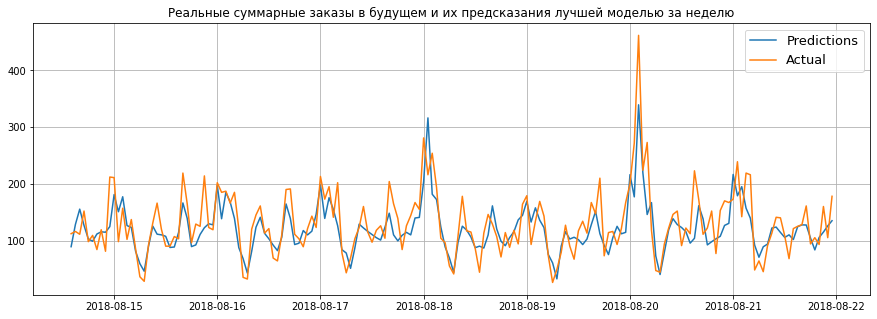

In [120]:
plt.figure(figsize=(15, 5))
plt.title("Реальные суммарные заказы в будущем и их предсказания лучшей моделью за неделю")
plt.plot(predictions_test['2018-08-14':'2018-08-21'], label = "Predictions")
plt.plot(target_test['2018-08-14':'2018-08-21'], label = "Actual")
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48